In [1]:
# download dataset
!wget --no-check-certificate "https://drive.google.com/uc?export=download&id=1qc8J2G33D1EJp7UcHjFsC8TM9En4mlnN" -O international-airline-passengers.txt
# !wget --no-check-certificate "https://drive.google.com/uc?export=download&id=1sqDa14EfBkGzIahLawTjQLR__lI0dBg0" -O Timeline.txt

--2018-07-20 17:42:45--  https://drive.google.com/uc?export=download&id=1qc8J2G33D1EJp7UcHjFsC8TM9En4mlnN
Resolving drive.google.com (drive.google.com)... 216.58.200.238, 2404:6800:4008:802::200e
Connecting to drive.google.com (drive.google.com)|216.58.200.238|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-68-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/dr8mgt28r7ovpjphoj1su5ei9i0iqip0/1532073600000/03883088111541851449/*/1qc8J2G33D1EJp7UcHjFsC8TM9En4mlnN?e=download [following]
--2018-07-20 17:42:45--  https://doc-0s-68-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/dr8mgt28r7ovpjphoj1su5ei9i0iqip0/1532073600000/03883088111541851449/*/1qc8J2G33D1EJp7UcHjFsC8TM9En4mlnN?e=download
Resolving doc-0s-68-docs.googleusercontent.com (doc-0s-68-docs.googleusercontent.com)... 216.58.200.225, 2404:6800:4008:802::2001
Connecting to doc-0s-68-docs.googleusercontent.com (doc-0s-68-docs.

In [2]:
ls

international-airline-passengers.txt  rnn_example_LiSu.ipynb


In [3]:
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import SimpleRNN
from keras.layers import GRU
from keras.layers import Input
from keras.layers import merge
from keras.layers import Permute
from keras.layers import Flatten
from keras.layers import RepeatVector
from keras.layers import Lambda
from keras.layers import Multiply
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# fix random seed for reproducibility
np.random.seed(7)

# load the dataset
dataset = np.loadtxt('international-airline-passengers.txt')
plt.plot(dataset)
plt.show()
dataset = dataset.astype('float32')
dataset = dataset.reshape(-1,1)

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

/home/nelson/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


96 48


In [4]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

def attention_3d_block(inputs, look_back):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    a = Permute((2, 1))(inputs)
    # a = Reshape((input_dim, TIME_STEPS))(a) # this line is not useful. It's just to know which dimension is what.
    a = Dense(look_back, activation='softmax')(a)
    # if SINGLE_ATTENTION_VECTOR:
    #     a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
    #     a = RepeatVector(input_dim)(a)
    a_probs = Permute((2, 1), name='attention_vec')(a)
    output_attention_mul = merge([inputs, a_probs], name='attention_mul', mode='mul')
    return output_attention_mul

def model_lstm(look_back):
    inputs = Input(shape=(look_back, 1))
    lstm_out = LSTM(4, input_shape=(look_back, 1))(inputs)
    output = Dense(1)(lstm_out)
    model = Model(input=[inputs], output=output)
    return model
  
def model_attention_applied_after_lstm(look_back):
    # using the model class API
    inputs = Input(shape=(look_back, 1))
    lstm_out = LSTM(4, input_shape=(look_back, 1), return_sequences=True)(inputs)
    a = Permute((2, 1))(lstm_out)
    a = Dense(look_back, activation='softmax')(lstm_out)
    a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
    a = RepeatVector(4)(a)
    a_probs = Permute((2, 1), name='attention_vec')(a)
    attention_mul = Multiply()([lstm_out, a_probs]) # 
    attention_mul = Flatten()(attention_mul)
    output = Dense(1)(attention_mul) # activation='linear' if not specified
    model = Model(input=[inputs], output=output)
    return model

In [5]:
# reshape into X=t and Y=t+1
look_back = 4
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [batch_size (samples?), time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
print(trainX.shape)

# create and fit the LSTM network
# model = Sequential()
# model.add(GRU(4, input_shape=(look_back, 1)))
# model.add(Dense(1))
# model.compile(loss='mean_squared_error', optimizer='adam')
# model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2)


inputs = Input(shape=(look_back, 1))
lstm_out = LSTM(4, input_shape=(look_back, 1), return_sequences=True)(inputs)
a = Permute((2, 1))(lstm_out)
a = Dense(look_back, activation='softmax')(lstm_out)
a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
a = RepeatVector(4)(a)
a_probs = Permute((2, 1), name='attention_vec')(a)
attention_mul = Multiply()([lstm_out, a_probs])
attention_mul = Flatten()(attention_mul)
output = Dense(1)(attention_mul) # activation='linear' if not specified
#output = Dense(1)(lstm_out)

model = model_lstm(look_back)
# model = Model(input=[inputs], output=output)
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))



(91, 4, 1)


/home/nelson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


Epoch 1/100
 - 0s - loss: 0.0370
Epoch 2/100
 - 0s - loss: 0.0154
Epoch 3/100
 - 0s - loss: 0.0129
Epoch 4/100
 - 0s - loss: 0.0113
Epoch 5/100
 - 0s - loss: 0.0094
Epoch 6/100
 - 0s - loss: 0.0080
Epoch 7/100
 - 0s - loss: 0.0070
Epoch 8/100
 - 0s - loss: 0.0059
Epoch 9/100
 - 0s - loss: 0.0056
Epoch 10/100
 - 0s - loss: 0.0051
Epoch 11/100
 - 0s - loss: 0.0049
Epoch 12/100
 - 0s - loss: 0.0049
Epoch 13/100
 - 0s - loss: 0.0050
Epoch 14/100
 - 0s - loss: 0.0046
Epoch 15/100
 - 0s - loss: 0.0045
Epoch 16/100
 - 0s - loss: 0.0045
Epoch 17/100
 - 0s - loss: 0.0045
Epoch 18/100
 - 0s - loss: 0.0046
Epoch 19/100
 - 0s - loss: 0.0046
Epoch 20/100
 - 0s - loss: 0.0044
Epoch 21/100
 - 0s - loss: 0.0044
Epoch 22/100
 - 0s - loss: 0.0043
Epoch 23/100
 - 0s - loss: 0.0043
Epoch 24/100
 - 0s - loss: 0.0044
Epoch 25/100
 - 0s - loss: 0.0043
Epoch 26/100
 - 0s - loss: 0.0044
Epoch 27/100
 - 0s - loss: 0.0042
Epoch 28/100
 - 0s - loss: 0.0043
Epoch 29/100
 - 0s - loss: 0.0042
Epoch 30/100
 - 0s - lo

In [6]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict


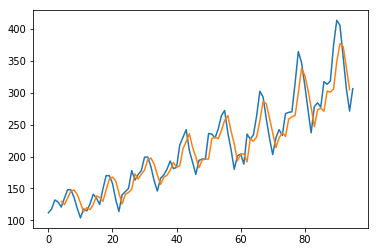

In [7]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset[:int(len(dataset)*0.67)]))
plt.plot(trainPredictPlot[:int(len(dataset)*0.67)])
#plt.plot(testPredictPlot)
plt.show()

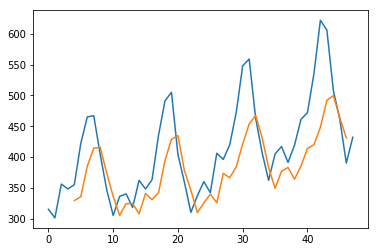

In [8]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset[int(len(dataset)*0.67):]))
#plt.plot(trainPredictPlot)
plt.plot(testPredictPlot[int(len(dataset)*0.67):])
plt.show()

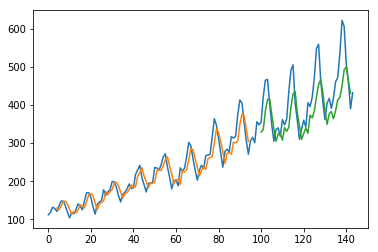

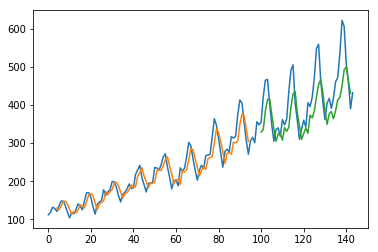

In [9]:

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()